# NLP Análisis de sentimientos reviews Airbnb París

In [25]:
# Import libraries

# Manejo de datos
import pandas as pd
import geopandas as gpd
import swifter


# Visualización de datos
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

#Procesamiento de Lenguaje Natural (NLP)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from functools import partial

[nltk_data] Downloading package punkt to /Users/diana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/diana/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Lectura de los datos

In [4]:
reviews = pd.read_csv('../data/reviews_summary.csv')
reviews.head()

,listing_id,id,date,comments,language
0,3109,123127969,2016-12-27,The host canceled this reservation the day bef...,en
1,3109,123274144,2016-12-28,The host canceled this reservation 2 days befo...,en
2,3109,207127433,2017-10-28,Tout s'est bien déroulé. Merci bien. PG,fr
3,3109,208779822,2017-11-03,Un petit nid fouiller douillet situé dans app...,fr
4,3109,234257457,2018-02-12,The host canceled this reservation 8 days befo...,en


In [6]:
# Obtener la distribución de idiomas
language_distribution = reviews['language'].value_counts()
language_distribution

language
en     946094
fr     442075
es      69715
de      45902
it      28181
        ...  
kv          1
te          1
ckb         1
my          1
tl          1
Name: count, Length: 101, dtype: int64

In [8]:
# Los tres idiomas más comunes
top_three_languages = language_distribution.head(3)
top_three_languages

language
en    946094
fr    442075
es     69715
Name: count, dtype: int64

Los 3 idiomas más usados son Inglés, frnacés y español

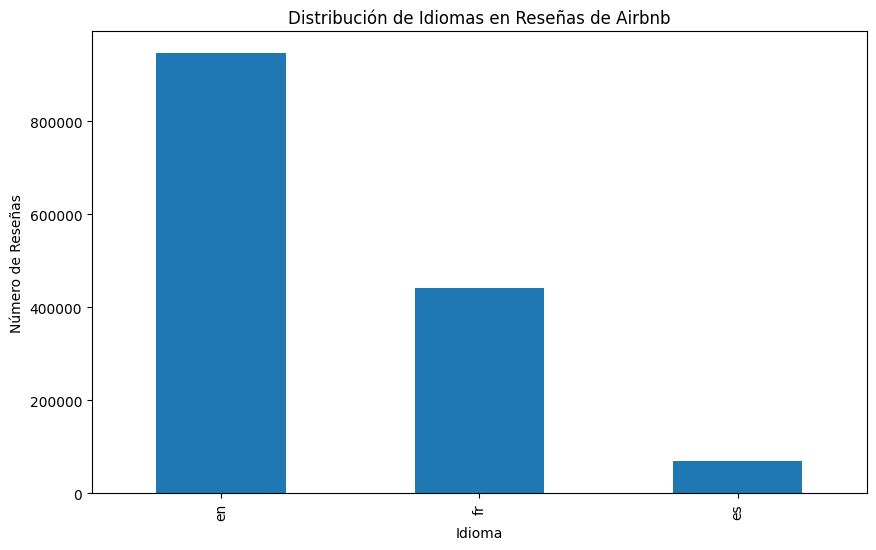

In [10]:
# Gráfico de barras para la distribución de idiomas
top_three_languages.plot(kind='bar', figsize=(10, 6))
plt.title('Distribución de Idiomas en Reseñas de Airbnb')
plt.xlabel('Idioma')
plt.ylabel('Número de Reseñas')
plt.show()

## Palabras más usadas en los 3 idiomas más comunes

In [15]:
df_english = reviews[reviews['language'] == 'en']
df_spanish = reviews[reviews['language'] == 'es']
df_french = reviews[reviews['language'] == 'fr']

### NLP (Procesamiento Natural del Lenguaje)

In [11]:
# Functions to process the reviews
tokenizer = RegexpTokenizer(r'\w+')

In [14]:
spanish_stopwords = stopwords.words('spanish')
english_stopwords = stopwords.words('english')
french_stopwords = stopwords.words('french')

In [12]:
def get_top_n_words(corpus, stopwords_list, n=1, k=1):
    vec = CountVectorizer(ngram_range=(k, k), stop_words=stopwords_list)
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

In [16]:
def display_top_n_words(df, stopwords_list):
    common_words = get_top_n_words(df, stopwords_list, 20, 1)
    for word, freq in common_words:
        print(word, freq)
        
    df_top_words = pd.DataFrame(common_words, columns=["words", "count"])
    df_top_words.groupby("words").sum()["count"].sort_values(ascending=False).plot(
        kind="bar", title="Top 20 words"
    )

apartment 593866
great 537752
stay 445585
location 433480
place 400586
paris 373651
host 236054
us 227432
would 226669
nice 226401
clean 224046
metro 217591
perfect 191382
everything 190248
recommend 184247
good 179942
well 174240
close 170677
really 152850
restaurants 152410


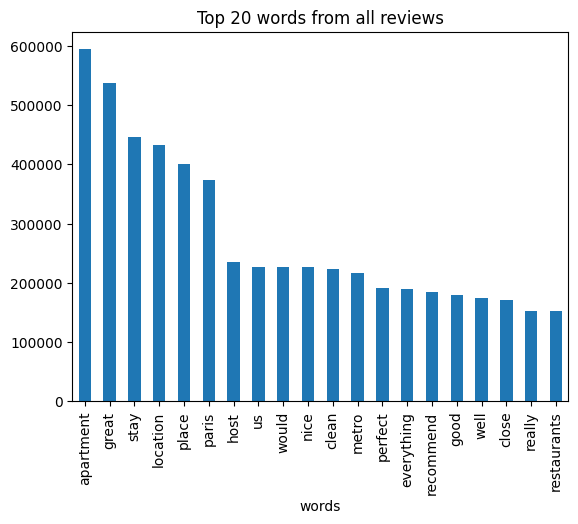

In [18]:
display_top_n_words(df_english['comments'], english_stopwords)

Las palabras más frecuentes reflejan aspectos positivos de la experiencia de Airbnb, con énfasis en la calidad del lugar ("clean", "nice", "perfect") y su ubicación ("location", "paris", "metro", "close", "restaurants")

bien 27557
apartamento 23358
ubicación 19633
excelente 17799
metro 17649
cerca 16183
buena 15082
departamento 14997
lugar 12739
limpio 10238
ubicado 9166
paris 8926
parís 8261
zona 8186
si 8157
cómodo 8144
amable 8110
casa 7999
estancia 7314
recomendable 7018


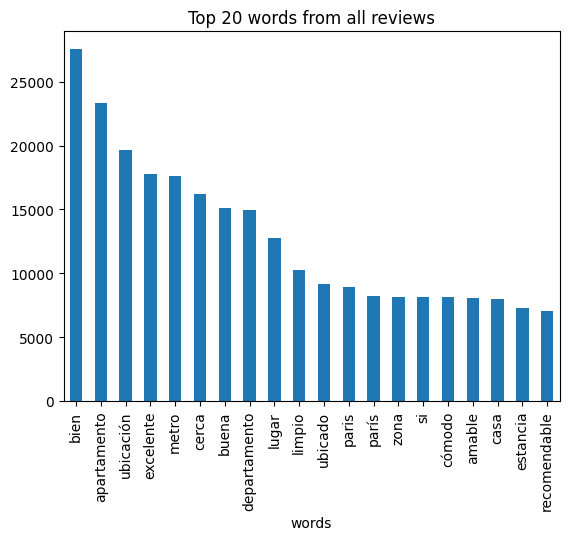

In [19]:
display_top_n_words(df_spanish['comments'], spanish_stopwords)

Las palabras reflejan una visión positiva, con un enfoque en la ubicación ("ubicación", "metro", "cerca", "zona") y la calidad del alojamiento ("limpio", "cómodo").
"Excelente" y "recomendable" muestran que los huéspedes tienden a dejar reseñas muy favorables.

très 498525
appartement 259750
bien 246216
séjour 126690
situé 117057
agréable 93388
propre 91697
tout 89747
logement 86738
calme 84527
recommande 83721
paris 81016
bon 70030
quartier 65321
merci 62600
super 59742
hôte 58860
accueil 55676
métro 53813
parfait 53670


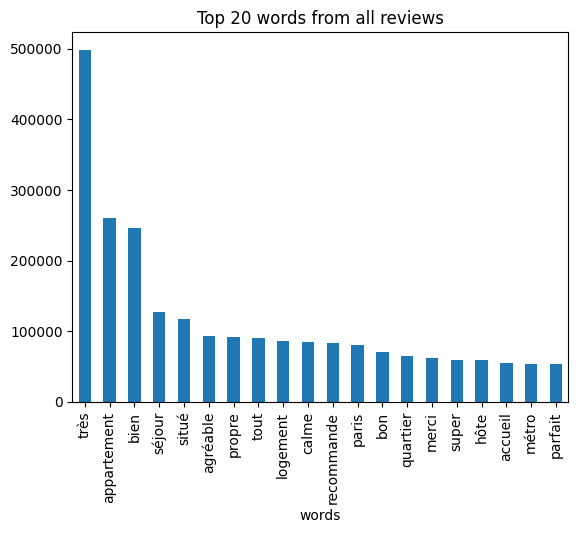

In [20]:
display_top_n_words(df_french['comments'], french_stopwords)

Hay énfasis en la calidad del lugar ("agréable", "propre", "logement", "calme") y en la ubicación ("situé", "paris", "quartier", "métro")

### Análisis de Sentimientos usando VADER

Análisis de los reviews en ingles con VADER para identificar comentarios positivos y negativos. VADER tiene limitaciones con otros idiomas por lo que solo trabajaremos esta sección con los reviews en inglés

In [21]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/diana/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [22]:
from nltk.sentiment import SentimentIntensityAnalyzer

In [23]:
sia = SentimentIntensityAnalyzer()

In [26]:
sentiments = df_english['comments'].swifter.apply(lambda review: sia.polarity_scores(review))

Pandas Apply:   0%|          | 0/946094 [00:00<?, ?it/s]

El método polarity_scores devuelve un diccionario con cuatro entradas: 'neg' para la probabilidad de ser negativo, 'neu' para neutral, 'pos' para positivo, y 'compound', que es una métrica que resume los anteriores. Generalmente, si 'compound' es mayor que 0.05, el texto se considera positivo, si es menor que -0.05, se considera negativo, y si está entre -0.05 y 0.05, se considera neutral.

In [27]:
sentiments

0          {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
1          {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
4          {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
6          {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
7          {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
                                 ...                        
1619574    {'neg': 0.0, 'neu': 0.565, 'pos': 0.435, 'comp...
1619575    {'neg': 0.02, 'neu': 0.668, 'pos': 0.311, 'com...
1619578    {'neg': 0.0, 'neu': 0.611, 'pos': 0.389, 'comp...
1619594    {'neg': 0.0, 'neu': 0.695, 'pos': 0.305, 'comp...
1619599    {'neg': 0.0, 'neu': 0.575, 'pos': 0.425, 'comp...
Name: comments, Length: 946094, dtype: object

In [29]:
# Convertir la serie de diccionarios a un DataFrame
sentiments_df = sentiments.swifter.apply(pd.Series)

Pandas Apply:   0%|          | 0/946094 [00:00<?, ?it/s]

In [30]:
# Concatenar el nuevo DataFrame de sentimientos con el DataFrame original
df_english = pd.concat([df_english, sentiments_df], axis=1)

In [31]:
df_english.head()

,listing_id,id,date,comments,language,neg,neu,pos,compound
0,3109,123127969,2016-12-27,The host canceled this reservation the day bef...,en,0.0,1.0,0.0,0.0
1,3109,123274144,2016-12-28,The host canceled this reservation 2 days befo...,en,0.0,1.0,0.0,0.0
4,3109,234257457,2018-02-12,The host canceled this reservation 8 days befo...,en,0.0,1.0,0.0,0.0
6,3109,297207211,2018-07-27,The host canceled this reservation 2 days befo...,en,0.0,1.0,0.0,0.0
7,3109,360052439,2018-12-19,The host canceled this reservation 15 days bef...,en,0.0,1.0,0.0,0.0


Hay varios comentarios que son auto generados por airbnb, vamos a eliminarlos

In [35]:
auto_generated_text = "This is an automated posting."

# Crear una máscara booleana donde los comentarios NO contienen el texto autogenerado
mask = ~df_english['comments'].str.contains(auto_generated_text, na=False)

# Aplicar la máscara al mismo DataFrame para excluir las reseñas autogeneradas
df_english = df_english[mask]

In [36]:
df_english.shape

(933668, 9)

Se eliminaron 685,932 reseñas auto generadas!!

In [41]:
df_english = df_english[df_english['comments'].str.contains(r'\b\w+\b')]

In [42]:
df_english.shape

(930072, 9)

Se eliminaron 3596 reseñas sin palabras!!

In [43]:
df_english.head()

,listing_id,id,date,comments,language,neg,neu,pos,compound
9,5396,4824,2009-06-30,Perfect location!! Nasrine was a delight and m...,en,0.034,0.587,0.379,0.9629
10,52931,750591941505043764,2022-11-01,Very nice accomodation from each perspective!1...,en,0.000,0.860,0.140,0.9671
11,5396,4968,2009-07-03,This is a nice place in a great location in Pa...,en,0.000,0.522,0.478,0.9682
12,5396,5240,2009-07-08,"Nice studio, very clean, very quiet, in a grea...",en,0.000,0.725,0.275,0.9520
13,5396,9619,2009-09-10,"Superb location, great studio. \rA slice of Pa...",en,0.000,0.679,0.321,0.9442


In [45]:
neutral_comments_df = df_english[(df_english['compound'] >= -0.1) & (df_english['compound'] <= 0.1)]
neutral_comments_df.head()

,listing_id,id,date,comments,language,neg,neu,pos,compound
128,53353,664342860072665894,2022-07-05,Very spacious and quiet stay. After two weeks...,en,0.000,1.000,0.000,0.0000
156,5396,83651706,2016-07-03,The apt was very much as it appeared in the ph...,en,0.061,0.886,0.053,-0.0788
244,5396,324897007,2018-09-18,"Frankly, at first sight the apartment's small ...",en,0.085,0.829,0.086,0.0553
297,5396,430988384,2019-03-31,Good location. Uncomfortable bed.,en,0.347,0.267,0.387,0.0772
351,55071,613212,2011-10-10,The host canceled my reservation 5 days before...,en,0.000,1.000,0.000,0.0000


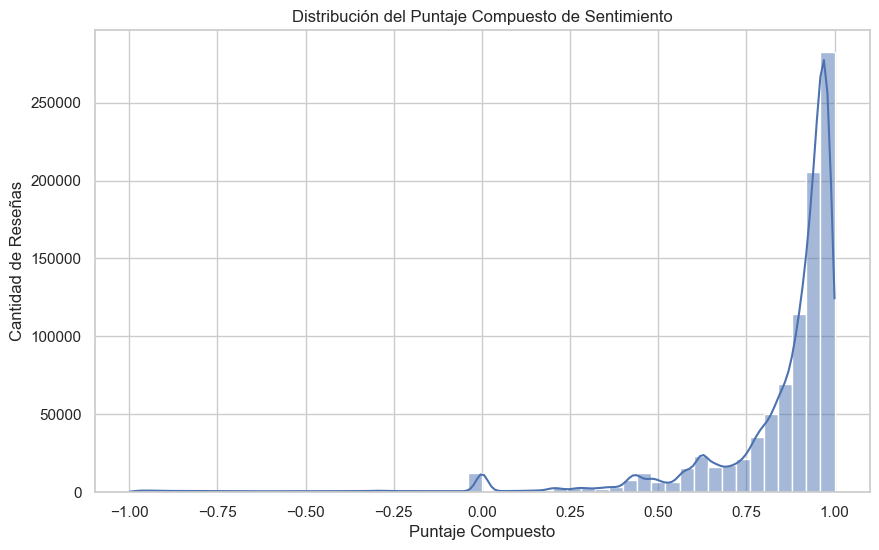

In [46]:
sns.set(style="whitegrid")

# Histograma del puntaje compuesto
plt.figure(figsize=(10, 6))
sns.histplot(df_english['compound'], bins=50, kde=True)
plt.title('Distribución del Puntaje Compuesto de Sentimiento')
plt.xlabel('Puntaje Compuesto')
plt.ylabel('Cantidad de Reseñas')
plt.show()

Hay un pico significativo en el extremo derecho de la gráfica en el valor de 1.0. Esto indica que una gran cantidad de reseñas tienen un puntaje compuesto de sentimiento muy positivo, lo que sugiere que las reseñas con sentimiento positivo son comunes en el conjunto de datos.

La distribución de los puntajes compuestos está claramente sesgada hacia la derecha, indicando que hay más reseñas con sentimientos positivos que negativos.

Hay menos reseñas con puntajes compuestos negativos, como se ve por el área vacía del lado izquierdo del histograma (valores entre -1 y 0). Esto sugiere que las reseñas negativas son menos frecuentes.

Hay una pequeña cantidad de reseñas con un puntaje compuesto de 0, que probablemente representan comentarios neutrales.

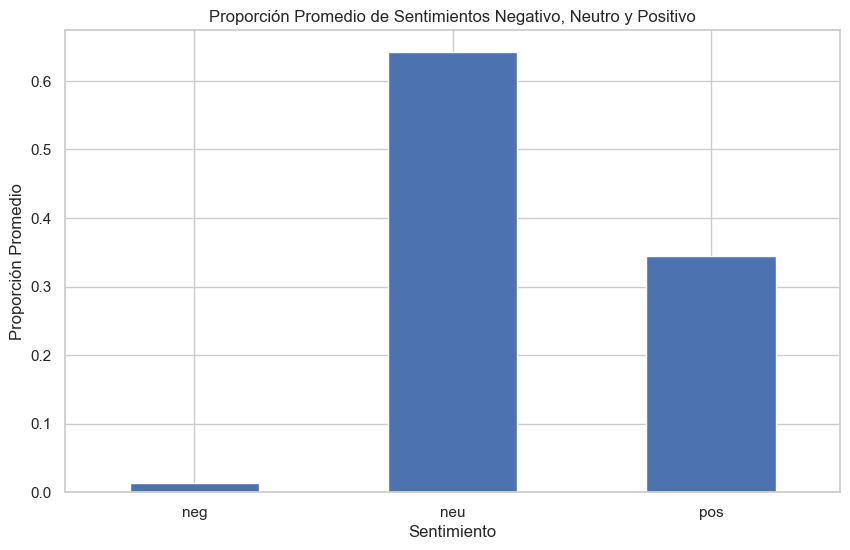

In [47]:
# Gráfico de barras de la proporción promedio de sentimientos
sentiment_counts = df_english[['neg', 'neu', 'pos']].mean()
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar')
plt.title('Proporción Promedio de Sentimientos Negativo, Neutro y Positivo')
plt.xlabel('Sentimiento')
plt.ylabel('Proporción Promedio')
plt.xticks(rotation=0)
plt.show()

- La proporción promedio de comentarios negativos es relativamente pequeña. Esto sugiere que las experiencias negativasen las reseñas son menos comunes.

- La barra de sentimientos neutrales es la más alta, lo que implica que la mayoría de los comentarios se consideran neutrales. Estos podrían ser comentarios que describen la estancia sin expresar emociones fuertes o que contienen elementos tanto positivos como negativos.

- La barra de sentimientos positivos es menor que la de neutrales pero mayor que la de negativos. Esto refleja que hay una cantidad considerable de reseñas con comentarios positivos, aunque no son tan predominantes como los neutrales.